In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit

In [2]:
pauli_list = [
    np.eye(2),
    np.array([[0.0, 1.0], [1.0, 0.0]]),
    np.array([[0, -1.0j], [1.0j, 0.0]]),
    np.array([[1.0, 0.0], [0.0, -1.0]]),
]
s_to_pauli = {
    "I": pauli_list[0],
    "X": pauli_list[1],
    "Y": pauli_list[2],
    "Z": pauli_list[3],
}

# The State (i.e. Channel)

Here we'll start with the all zeros state $|0\rangle ^{\otimes n}$, apply gates to form a $n$ qubit GHZ state and perfom shadow state tomography to determine the density matrix

In [3]:
def channel(N,qc):
    '''create an N qubit GHZ state '''
    qc.h(0)
    if N>=2: qc.cx(0,1)
    if N>=3: qc.cx(0,2)
    if N>=4: qc.cx(1,3)
    if N>4: raise NotImplementedError(f"{N} not implemented!")

    
def bitGateMap(qc,g,qi):
    '''Map X/Y/Z string to qiskit ops'''
    if g=="X":
        qc.h(qi)
    elif g=="Y":
        qc.sdg(qi)
        qc.h(qi)
    elif g=="Z":
        pass
    else:
        raise NotImplementedError(f"Unknown gate {g}")
def Minv(N,X):
    '''inverse shadow channel'''
    return ((2**N+1.))*X - np.eye(2**N)

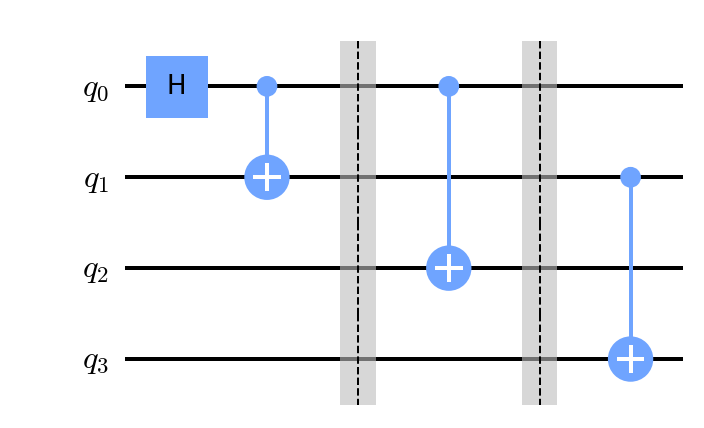

In [4]:
qc = qiskit.QuantumCircuit(4)
qc.h(0)
qc.cx(0,1)
qc.barrier()
qc.cx(0,2)
qc.barrier()
qc.cx(1,3)

qc.draw(output='mpl')

    

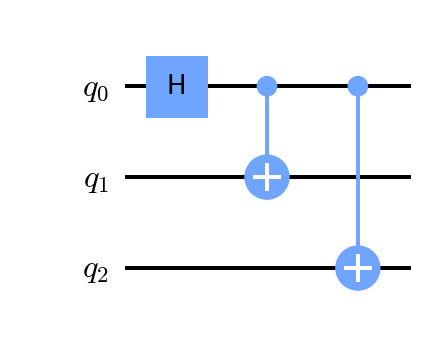

In [5]:
qc = qiskit.QuantumCircuit(3)
channel(3,qc)
qc.draw(output='mpl')

    

# Fixed $n$

Classical Shadow Procedure:

1. Generate the state
2. Apply random rotation
3. measure bit string 
4. repeat to 1

## Clifford

Let's first do traditional state tomography

In [6]:
nShadows = 100
reps = 1
N = 2
rng = np.random.default_rng(1717)
cliffords = [qiskit.quantum_info.random_clifford(N, seed=rng) for _ in range(nShadows)]

qc = qiskit.QuantumCircuit(N)
channel(N,qc)

results = []
for cliff in cliffords:
    qc_c  = qc.compose(cliff.to_circuit())

    counts = qiskit.quantum_info.Statevector(qc_c).sample_counts(reps)
    results.append(counts)

In [7]:
qc.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

In [8]:
qc_c.draw()

┌───┐      ┌───┐            ┌───┐ ┌───┐
q_0: ┤ H ├──■───┤ Z ├────────■───┤ H ├─┤ S ├
     └───┘┌─┴─┐┌┴───┴┐┌───┐┌─┴─┐┌┴───┴┐├───┤
q_1: ─────┤ X ├┤ Sdg ├┤ H ├┤ X ├┤ Sdg ├┤ H ├
          └───┘└─────┘└───┘└───┘└─────┘└───┘

Now we'll construct the shadow directly (forming a full density matrix). This will make some future post processing steps easy
$$
\hat{\rho} = \mathcal{M}^{-1}\left(U^\dagger|b\rangle\langle b|U \right) = (2^N+1)U^\dagger|b\rangle\langle b|U-I
$$

In [9]:
shadows = []
for cliff, res in zip(cliffords, results):
    mat    = cliff.adjoint().to_matrix()
    for bit,count in res.items():
        Ub = mat[:,int(bit,2)] # this is Udag|b>
        shadows.append(Minv(N,np.outer(Ub,Ub.conj()))*count)

rho_shadow = np.sum(shadows,axis=0)/(nShadows*reps)

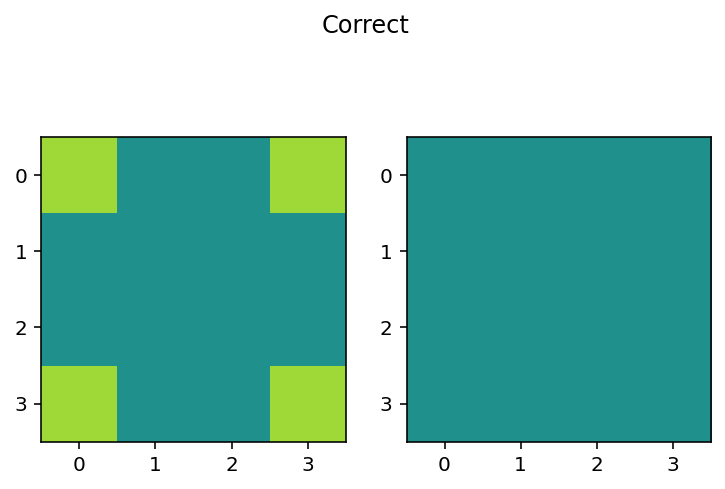

---


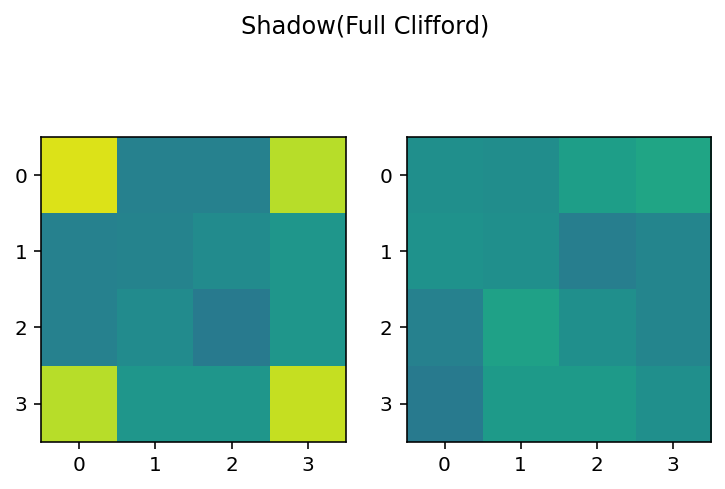

In [10]:
rho_actual = qiskit.quantum_info.DensityMatrix(qc).data


plt.subplot(121)
plt.suptitle("Correct")
plt.imshow(rho_actual.real,vmax=0.7,vmin=-0.7)
plt.subplot(122)
plt.imshow(rho_actual.imag,vmax=0.7,vmin=-0.7)
plt.show()
print("---")

plt.subplot(121)
plt.suptitle("Shadow(Full Clifford)")
plt.imshow(rho_shadow.real,vmax=0.7,vmin=-0.7)
plt.subplot(122)
plt.imshow(rho_shadow.imag,vmax=0.7,vmin=-0.7)
plt.show()

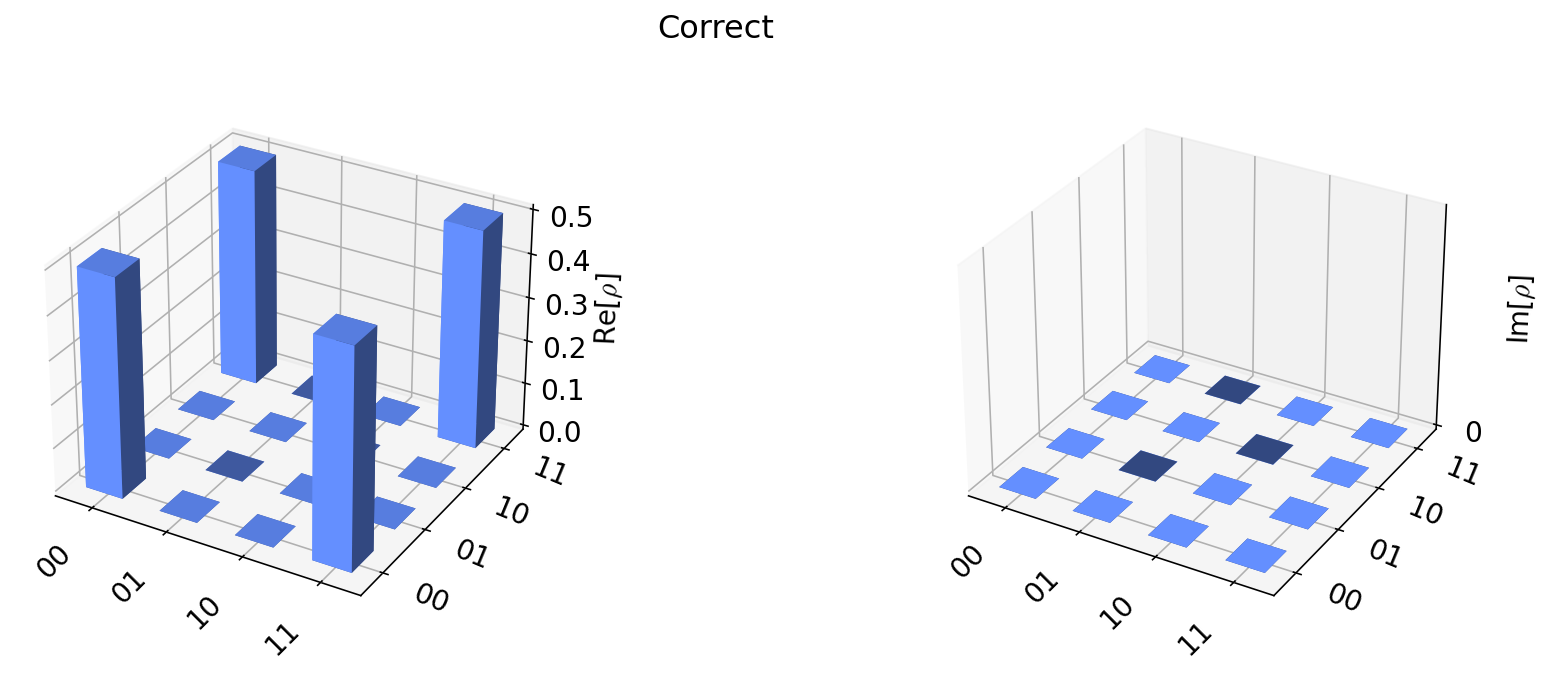

In [11]:
qiskit.visualization.state_visualization.plot_state_city(rho_actual,title="Correct")


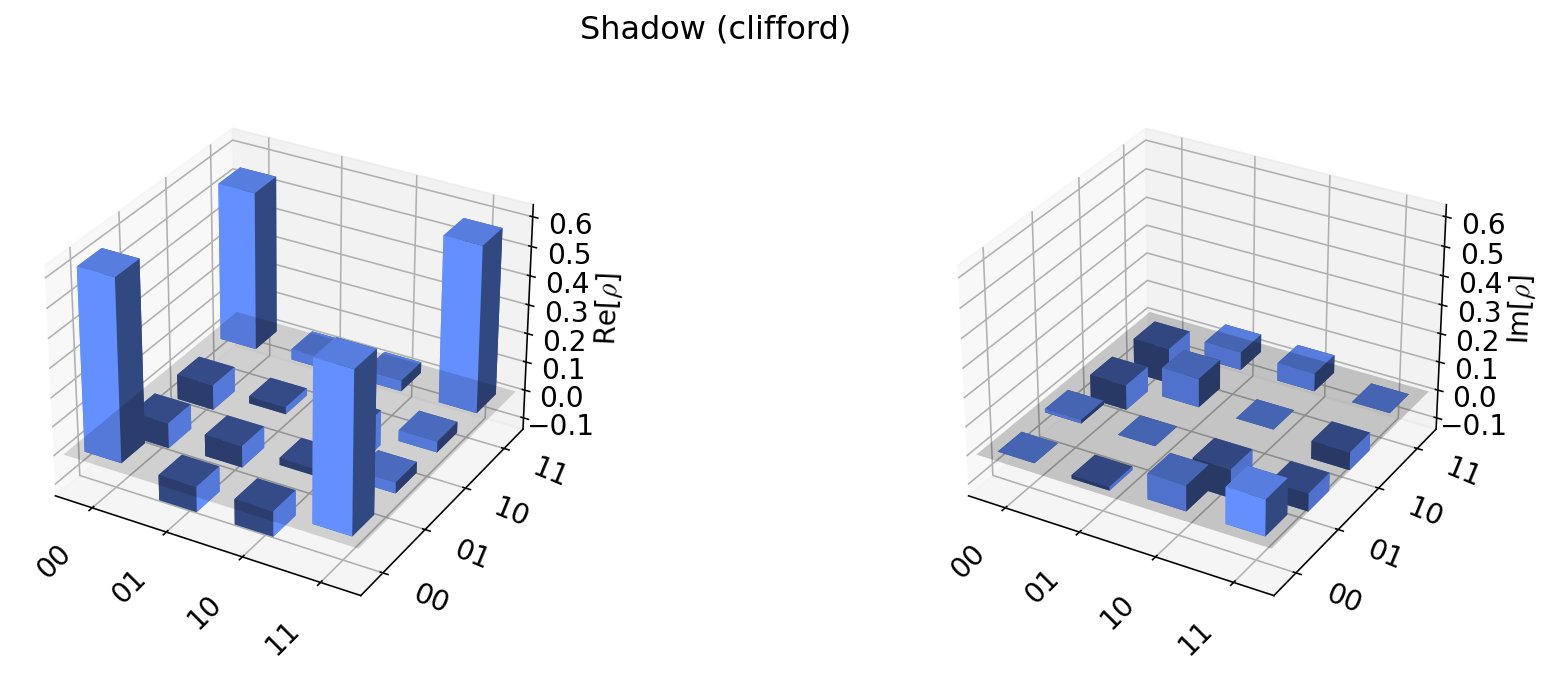

In [12]:
qiskit.visualization.state_visualization.plot_state_city(rho_shadow,title="Shadow (clifford)")


## Pauli

Repeating the above, but now with a Pauli string. Note this is effectively the same as single qubit Cliffords

In [13]:
nShadows = 10_000
N = 2

rng = np.random.default_rng(1717)
scheme = [rng.choice(['X','Y','Z'],size=N) for _ in range(nShadows)]
labels, counts = np.unique(scheme,axis=0,return_counts=True)
    
qc = qiskit.QuantumCircuit(N)
channel(N,qc)

results = []
for bit_string,count in zip(labels,counts):
    qc_m = qc.copy() 
    # rotate the basis for each qubit
    for i,bit in enumerate(bit_string): bitGateMap(qc_m,bit,i) 
    counts = qiskit.quantum_info.Statevector(qc_m).sample_counts(count)
    results.append(counts)

Note: qiskit using little-endian encoding so $X_1|00\rangle = |10\rangle$

In [14]:
def rotGate(g):
    '''produces gate U such that U|psi> is in Pauli basis g'''
    if g=="X":
        return 1/np.sqrt(2)*np.array([[1.,1.],[1.,-1.]])
    elif g=="Y":
        return 1/np.sqrt(2)*np.array([[1.,-1.0j],[1.,1.j]])
    elif g=="Z":
        return np.eye(2)
    else:
        raise NotImplementedError(f"Unknown gate {g}")       

In [15]:
shadows = []
shots = 0
for pauli_string,counts in zip(labels,results):
    # iterate over measurements
     for bit,count in counts.items():
        mat = 1.
        for i,bi in enumerate(bit[::-1]):
            b = rotGate(pauli_string[i])[int(bi),:]
            mat = np.kron(Minv(1,np.outer(b.conj(),b)),mat)
        shadows.append(mat*count)
        shots+=count

rho_shadow = np.sum(shadows,axis=0)/(shots)

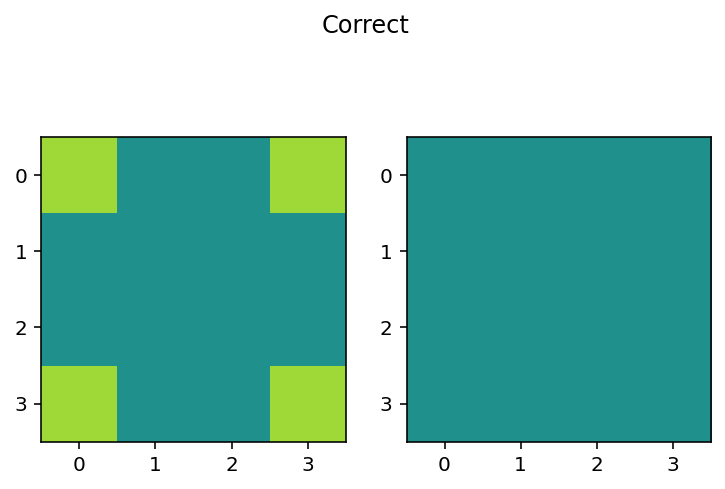

---


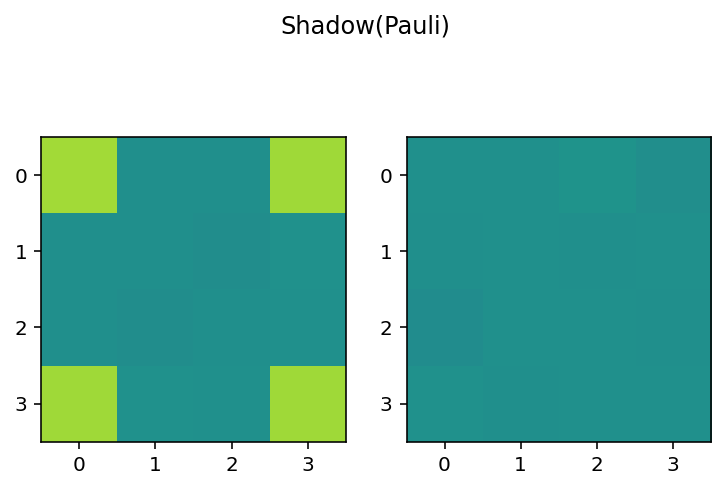

In [16]:
rho_actual = qiskit.quantum_info.DensityMatrix(qc).data


plt.subplot(121)
plt.suptitle("Correct")
plt.imshow(rho_actual.real,vmax=0.7,vmin=-0.7)
plt.subplot(122)
plt.imshow(rho_actual.imag,vmax=0.7,vmin=-0.7)
plt.show()
print("---")

plt.subplot(121)
plt.suptitle("Shadow(Pauli)")
plt.imshow(rho_shadow.real,vmax=0.7,vmin=-0.7)
plt.subplot(122)
plt.imshow(rho_shadow.imag,vmax=0.7,vmin=-0.7)
plt.show()